In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
train_cxr14 = pd.read_csv("/home/local/data/sophie/cxr14/train_cx14_node_21.csv")
test_cxr14 = pd.read_csv("/home/local/data/sophie/cxr14/test_cx14_node_21.csv")
train_pad = pd.read_csv("/home/local/data/sophie/padchest/train_pad_node_21.csv")
test_pad = pd.read_csv("/home/local/data/sophie/padchest/test_pad_node_21.csv")
test_openi = pd.read_csv("/home/local/data/sophie/openi/test_openi_node_21.csv")
test_jsrt = pd.concat([pd.read_csv("/home/local/data/sophie/jsrt/train_jsrt_node_21.csv"),pd.read_csv("/home/local/data/sophie/jsrt/test_jsrt_node_21.csv")]).reset_index(drop=True)

In [49]:
data_df = train_cxr14.copy()
data_df['partition'] = "train"
data_df = pd.concat([data_df, test_cxr14.copy()]).fillna("test")
data_df = pd.concat([data_df, train_pad.copy()]).fillna("train")
data_df = pd.concat([data_df, test_pad.copy()]).fillna("test")
data_df = pd.concat([data_df, test_openi.copy()]).fillna("test")
data_df = pd.concat([data_df, test_jsrt.copy()]).fillna("test")

In [50]:
data_df['png'] = data_df['mha'].apply(lambda x: x[:-3]+"png")

In [51]:
data_df['label'] = data_df['label'].astype(str)

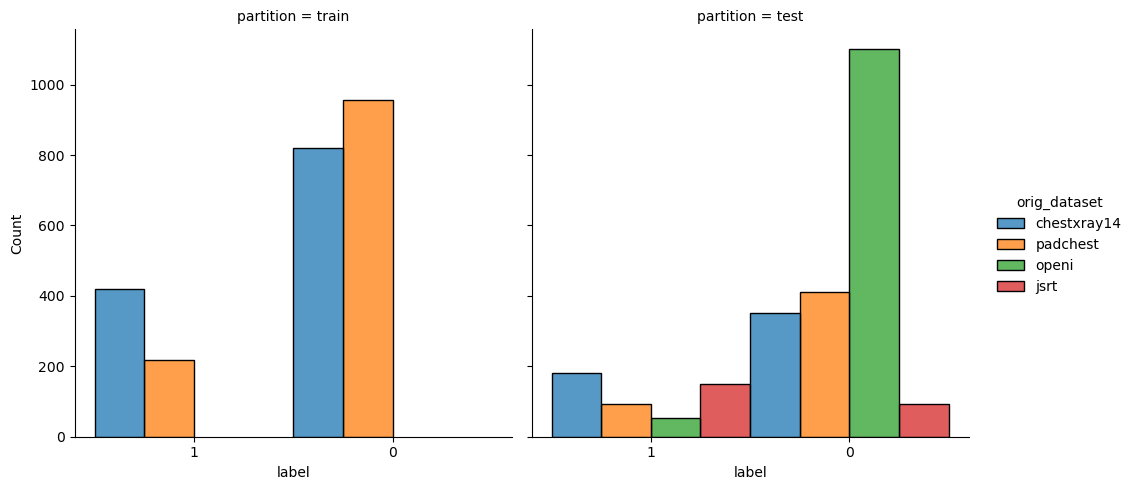

In [52]:
sns.displot(data_df, x='label',col='partition', hue='orig_dataset',multiple='dodge')

## Resampling Train & Test Distibution 

In [53]:
new_df = pd.DataFrame()
discard_df = pd.DataFrame()
for dataset in data_df.orig_dataset.unique():
    if len(data_df.query(f'orig_dataset == "{dataset}"').partition.unique())>1:
        for partition in data_df.query(f'orig_dataset == "{dataset}"').partition.unique():
            samples = data_df.query(f'orig_dataset == "{dataset}" & partition == "{partition}"').copy()
            vc = samples.label.value_counts()
            majority_label = vc.index[0]
            num_samples_to_remove = vc.iloc[0]-vc.iloc[1]
            maj_sample = samples.query(f"label=='{majority_label}'")[0:-num_samples_to_remove]
            new_df = pd.concat([new_df, maj_sample, samples.query(f"label=='{vc.index[1]}'") ]).reset_index(drop=True)
            discard_df = pd.concat([discard_df,samples.query(f"label=='{majority_label}'")[-num_samples_to_remove:]]).reset_index(drop=True)
    else:
        samples = data_df.query(f'orig_dataset == "{dataset}" & partition == "test"').copy()
        vc = samples.label.value_counts()
        majority_label = vc.index[0]
        num_samples_to_remove = vc.iloc[0]-vc.iloc[1]
        maj_sample = samples.query(f"label=='{majority_label}'")[0:-num_samples_to_remove]
        new_df = pd.concat([new_df, maj_sample, samples.query(f"label=='{vc.index[1]}'") ]).reset_index(drop=True)
        discard_df = pd.concat([discard_df,samples.query(f"label=='{majority_label}'")[-num_samples_to_remove:]]).reset_index(drop=True)
        

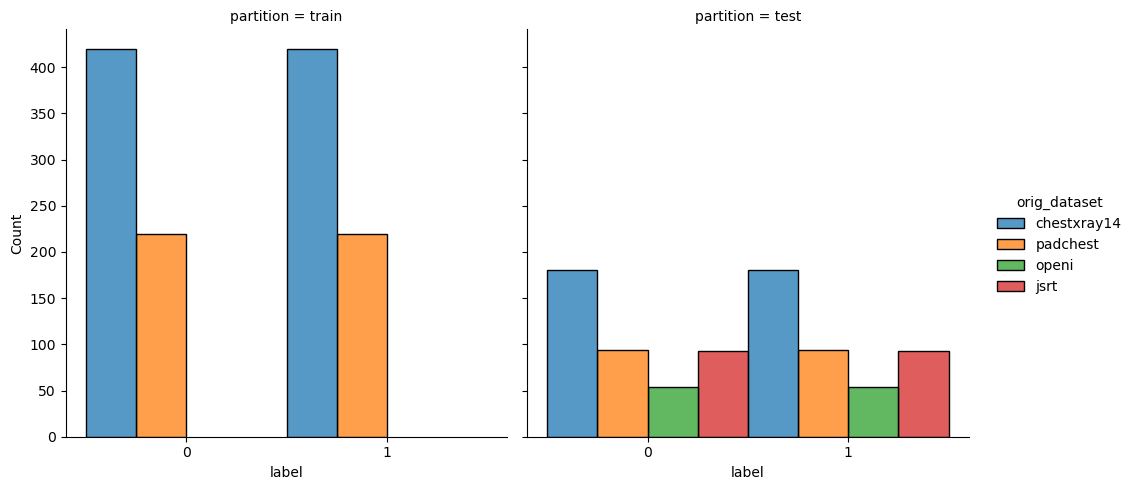

In [54]:
sns.displot(new_df, x='label',col='partition', hue='orig_dataset',multiple='dodge')

In [55]:
discard_df.head()

,original_image_name,orig_dataset,label,mha,Finding Labels,Patient ID,Patient Age,Patient Gender,original_image_width,original_image_height,...,Manufacturer,Modality,subtlety,nodule_size,malignant,shared_image_area,Dim_bin,partition,filename,png
0,00001422_000,chestxray14,0,c3304.mha,No Finding,1422,54.0,F,2048.0,2500.0,...,test,test,test,test,test,1048576.0,a,train,test,c3304.png
1,00001478_000,chestxray14,0,c3724.mha,No Finding,1478,52.0,F,2544.0,3032.0,...,test,test,test,test,test,1048576.0,a,train,test,c3724.png
2,00000472_000,chestxray14,0,c2558.mha,No Finding,472,41.0,F,2048.0,2500.0,...,test,test,test,test,test,1048576.0,a,train,test,c2558.png
3,00000738_000,chestxray14,0,c3857.mha,No Finding,738,25.0,F,2048.0,2500.0,...,test,test,test,test,test,1048576.0,a,train,test,c3857.png
4,00001886_000,chestxray14,0,c0942.mha,No Finding,1886,41.0,F,2992.0,2991.0,...,test,test,test,test,test,1048576.0,a,train,test,c0942.png


In [56]:
discard_df['orig_dataset'].unique()

array(['chestxray14', 'padchest', 'openi', 'jsrt'], dtype=object)

In [57]:
discard_df['ds'] = discard_df['orig_dataset'].apply(lambda x: "cxr14" if x =="chestxray14" else x ) 

In [58]:
import os
print("CXR14: \nTrain 0: {}".format(len(os.listdir("/home/local/data/sophie/node21_corrected_sampling/cxr14/flat_std_1024/train/0_normal")))+
    "\nTrain 1: {}".format(len(os.listdir("/home/local/data/sophie/node21_corrected_sampling/cxr14/flat_std_1024/train/1_nodule")))+ 
    "\n=============\nTest 0: {}".format(len(os.listdir("/home/local/data/sophie/node21_corrected_sampling/cxr14/flat_std_1024/test/0_normal")))+
    "\nTest 1: {}\n".format(len(os.listdir("/home/local/data/sophie/node21_corrected_sampling/cxr14/flat_std_1024/test/1_nodule")))
   )
print("Padchest: \nTrain 0: {}".format(len(os.listdir("/home/local/data/sophie/node21_corrected_sampling/padchest/flat_std_1024/train/0_normal")))+
    "\nTrain 1: {}".format(len(os.listdir("/home/local/data/sophie/node21_corrected_sampling/padchest/flat_std_1024/train/1_nodule")))+ 
    "\n=============\nTest 0: {}".format(len(os.listdir("/home/local/data/sophie/node21_corrected_sampling/padchest/flat_std_1024/test/0_normal")))+
    "\nTest 1: {}\n".format(len(os.listdir("/home/local/data/sophie/node21_corrected_sampling/padchest/flat_std_1024/test/1_nodule")))
   )

print("openi: \nTest 0: {}".format(len(os.listdir("/home/local/data/sophie/node21_corrected_sampling/openi/flat_std_1024/test/0_normal")))+
    "\nTest 1: {}\n".format(len(os.listdir("/home/local/data/sophie/node21_corrected_sampling/openi/flat_std_1024/test/1_nodule")))
   )
print("jsrt: \nTest 0: {}".format(len(os.listdir("/home/local/data/sophie/node21_corrected_sampling/jsrt/flat_std_1024/test/0_normal")))+
    "\nTest 1: {}\n".format(len(os.listdir("/home/local/data/sophie/node21_corrected_sampling/jsrt/flat_std_1024/test/1_nodule")))
   )

CXR14: 
Train 0: 819
Train 1: 421
Test 0: 351
Test 1: 180

Padchest: 
Train 0: 955
Train 1: 219
Test 0: 410
Test 1: 94

openi: 
Test 0: 1102
Test 1: 54

jsrt: 
Test 0: 94
Test 1: 150



In [59]:
test_jsrt.label.value_counts()

label
1    149
0     93
Name: count, dtype: int64

In [ ]:
sophie/node21_corrected_sampling/cxr14/flat_std_1024/train/normal

In [61]:
import os
base_path = "/home/local/data/sophie/node21_corrected_sampling"
for _, row in discard_df.iterrows():#"label","png"]]:
    os.remove(os.path.join(base_path,row.ds,"flat_std_1024", row.partition, "0_normal" if row.label == "0" else "1_nodule", row.png))

In [31]:
# import os
# base_path = "/home/local/data/sophie/node21_num_label_resample_test/"
# for _, row in discard_df.iterrows():#"label","png"]]:
#     os.remove(os.path.join(base_path,row.ds,"arch_seg/flat_std_1024", row.partition, "0_normal" if row.label == "0" else "1_nodule", row.png))

In [34]:
new_df.to_csv(os.path.join(base_path,"undersampled_testset_node_21.csv"))

In [95]:
# version 2: Add oversampling
new_df = pd.DataFrame()
discard_df = pd.DataFrame()
add_df = pd.DataFrame()
for dataset in data_df.orig_dataset.unique():
    if len(data_df.query(f'orig_dataset == "{dataset}"').partition.unique())>1:
        for partition in data_df.query(f'orig_dataset == "{dataset}"').partition.unique():
            samples = data_df.query(f'orig_dataset == "{dataset}" & partition == "{partition}"').copy()
            vc = samples.label.value_counts()
            if partition == "test":
                majority_label = vc.index[0]
                num_samples_to_remove = vc.iloc[0]-vc.iloc[1]
                maj_sample = samples.query(f"label=='{majority_label}'")[0:-num_samples_to_remove]
                new_df = pd.concat([new_df, maj_sample, samples.query(f"label=='{vc.index[1]}'") ]).reset_index(drop=True)
                discard_df = pd.concat([discard_df,samples.query(f"label=='{majority_label}'")[num_samples_to_remove:]]).reset_index(drop=True)
            else:
                ov_df = pd.DataFrame()
                minority_label = vc.index[1]
                num_minority_samples = vc.iloc[1]
                num_majority_samples = vc.iloc[0]
                majority_label = vc.index[0]
                multiplier = 1
                while num_minority_samples<num_majority_samples:
                    num_minority_samples+=vc.iloc[1]
                    multiplier += 1
                # print(f"Multiplier {multiplier} x {vc.iloc[1]} = {vc.iloc[1]*multiplier} : {vc.iloc[0]}")
                
                minority_samples = samples.query(f"label=='{minority_label}'").copy()
                for i in range(0,multiplier):
                    # keep adding undersampled class
                    ov_df = pd.concat([ov_df,minority_samples]).reset_index(drop=True)
                diff = len(ov_df) - num_majority_samples
                print(f"len(ov_df): {len(ov_df)}  maj_samples: {num_majority_samples}   diff: {diff}  len(ov_df[0:-diff]): {len(ov_df[0:-diff])}")
                
                new_df = pd.concat([new_df, ov_df[0:-diff], samples.query(f"label=='{majority_label}'") ]).reset_index(drop=True)
                add_df = pd.concat([add_df, ov_df[0:-diff]]).reset_index(drop=True)
                
    else:
        samples = data_df.query(f'orig_dataset == "{dataset}" & partition == "test"').copy()
        vc = samples.label.value_counts()
        majority_label = vc.index[0]
        num_samples_to_remove = vc.iloc[0]-vc.iloc[1]
        maj_sample = samples.query(f"label=='{majority_label}'")[0:-num_samples_to_remove]
        new_df = pd.concat([new_df, maj_sample, samples.query(f"label=='{vc.index[1]}'") ]).reset_index(drop=True)
        discard_df = pd.concat([discard_df,samples.query(f"label=='{majority_label}'")[num_samples_to_remove:]]).reset_index(drop=True)
        

len(ov_df): 840  maj_samples: 819   diff: 21  len(ov_df[0:-diff]): 819
len(ov_df): 1095  maj_samples: 955   diff: 140  len(ov_df[0:-diff]): 955


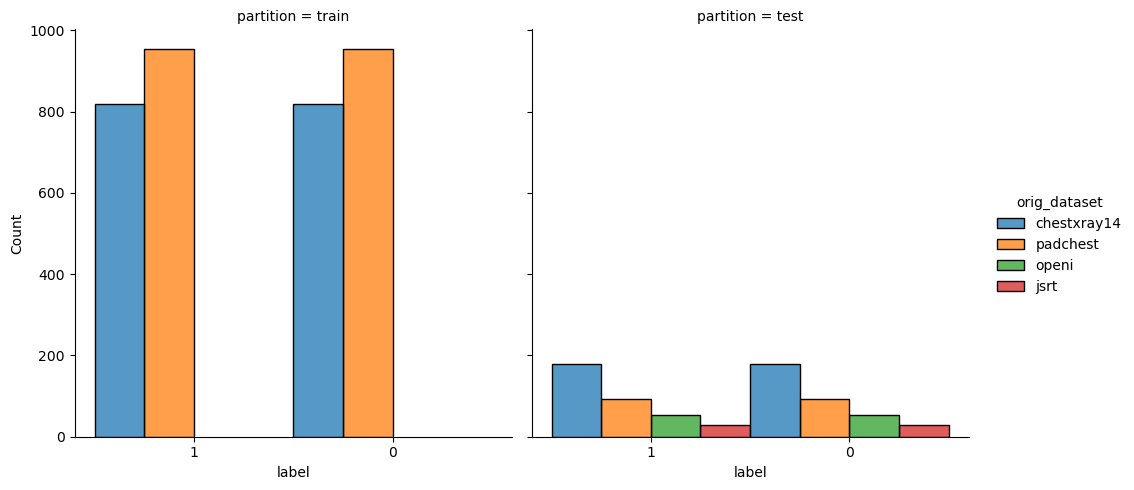

In [96]:
sns.displot(new_df, x='label',col='partition', hue='orig_dataset',multiple='dodge')

In [97]:
add_df.head()

,original_image_name,orig_dataset,label,mha,Finding Labels,Patient ID,Patient Age,Patient Gender,original_image_width,original_image_height,...,Manufacturer,Modality,subtlety,nodule_size,malignant,shared_image_area,Dim_bin,partition,filename,png
0,00028630_000,chestxray14,1,n0556.mha,Nodule,28630,59.0,F,2544.0,3056.0,...,test,test,test,test,test,1048576.0,a,train,test,n0556.png
1,00026911_005,chestxray14,1,n0726.mha,Nodule,26911,10.0,M,2506.0,2037.0,...,test,test,test,test,test,1048576.0,a,train,test,n0726.png
2,00006586_000,chestxray14,1,n0025.mha,Nodule,6586,60.0,M,2500.0,2048.0,...,test,test,test,test,test,1048576.0,a,train,test,n0025.png
3,00020070_007,chestxray14,1,n0097.mha,Nodule,20070,60.0,F,2542.0,2991.0,...,test,test,test,test,test,1048576.0,a,train,test,n0097.png
4,00008543_000,chestxray14,1,n0600.mha,Nodule,8543,59.0,M,2500.0,2048.0,...,test,test,test,test,test,1048576.0,a,train,test,n0600.png


In [104]:
"n0556.png"[:-4]+f"_idx{345}.png"

'n0556_idx345.png'

In [98]:
add_df['orig_dataset'].unique()

array(['chestxray14', 'padchest'], dtype=object)

In [100]:
add_df['ds'] = add_df['orig_dataset'].apply(lambda x: "cxr14" if x =="chestxray14" else x ) 
discard_df['ds'] = discard_df['orig_dataset'].apply(lambda x: "cxr14" if x =="chestxray14" else x ) 

In [114]:
import os, shutil
base_path = "/home/local/data/sophie/node21_oversampled/"

# copy files 
for i, row in add_df.iterrows():
    fp = os.path.join(base_path,row.ds,"arch_seg/flat_std_1024", row.partition, "0_normal" if row.label == "0" else "1_nodule")
    shutil.copy2(os.path.join(fp,row.png), os.path.join(fp,row.png[:-4]+f"_idx{i}.png"))
# delete files 
for _, row in discard_df.iterrows():#"label","png"]]:
    os.remove(os.path.join(base_path,row.ds,"arch_seg/flat_std_1024", row.partition, "0_normal" if row.label == "0" else "1_nodule", row.png))

In [34]:
# new_df.to_csv(os.path.join(base_path,"oversampled_testset_node_21.csv"))


## Combined PadCXR14 Sampling 

In [66]:
import os
print("PadchestCXR14: \nTrain 0: {}".format(len(os.listdir("/home/local/data/sophie/node21_combined/padcxr14/flat_std_1024/train/0_normal")))+
    "\nTrain 1: {}".format(len(os.listdir("/home/local/data/sophie/node21_combined/padcxr14/flat_std_1024/train/1_nodule")))+ 
    "\n=============\nCXR14:\nTest 0: {}".format(len(os.listdir("/home/local/data/sophie/node21_combined/padcxr14/flat_std_1024/test/cxr14/0_normal")))+
    "\nTest 1: {}\n".format(len(os.listdir("/home/local/data/sophie/node21_combined/padcxr14/flat_std_1024/test/cxr14/1_nodule")))
   )
print(
    "Padchest: \nTest 0: {}".format(len(os.listdir("/home/local/data/sophie/node21_combined/padcxr14/flat_std_1024/test/padchest/0_normal")))+
    "\nTest 1: {}\n".format(len(os.listdir("/home/local/data/sophie/node21_combined/padcxr14/flat_std_1024/test/padchest/1_nodule")))
   )

print("openi: \nTest 0: {}".format(len(os.listdir("/home/local/data/sophie/node21_combined/openi/flat_std_1024/test/0_normal")))+
    "\nTest 1: {}\n".format(len(os.listdir("/home/local/data/sophie/node21_combined/openi/flat_std_1024/test/1_nodule")))
   )
print("jsrt: \nTest 0: {}".format(len(os.listdir("/home/local/data/sophie/node21_combined/jsrt/flat_std_1024/test/0_normal")))+
    "\nTest 1: {}\n".format(len(os.listdir("/home/local/data/sophie/node21_combined/jsrt/flat_std_1024/test/1_nodule")))
   )

PadchestCXR14: 
Train 0: 819
Train 1: 1240
CXR14:
Test 0: 180
Test 1: 180

Padchest: 
Test 0: 94
Test 1: 94

openi: 
Test 0: 1049
Test 1: 54

jsrt: 
Test 0: 28
Test 1: 18



In [68]:
train_cxr14 = pd.read_csv("/home/local/data/sophie/cxr14/train_cx14_node_21.csv")
test_cxr14 = pd.read_csv("/home/local/data/sophie/cxr14/test_cx14_node_21.csv")
train_pad = pd.read_csv("/home/local/data/sophie/padchest/train_pad_node_21.csv")
test_pad = pd.read_csv("/home/local/data/sophie/padchest/test_pad_node_21.csv")
test_openi = pd.read_csv("/home/local/data/sophie/openi/test_openi_node_21.csv")
test_jsrt = pd.concat([pd.read_csv("/home/local/data/sophie/jsrt/train_jsrt_node_21.csv"),pd.read_csv("/home/local/data/sophie/jsrt/test_jsrt_node_21.csv")]).reset_index(drop=True)
data_df = pd.concat([train_cxr14.copy(),train_pad.copy()]).fillna("train")
data_df['orig_dataset'] = "padcxr14"
data_df['partition'] = "train"
data_df = pd.concat([data_df, test_cxr14.copy()]).fillna("test")
# data_df = pd.concat([data_df, train_pad.copy()]).fillna("train")
data_df = pd.concat([data_df, test_pad.copy()]).fillna("test")
data_df = pd.concat([data_df, test_openi.copy()]).fillna("test")
data_df = pd.concat([data_df, test_jsrt.copy()]).fillna("test")


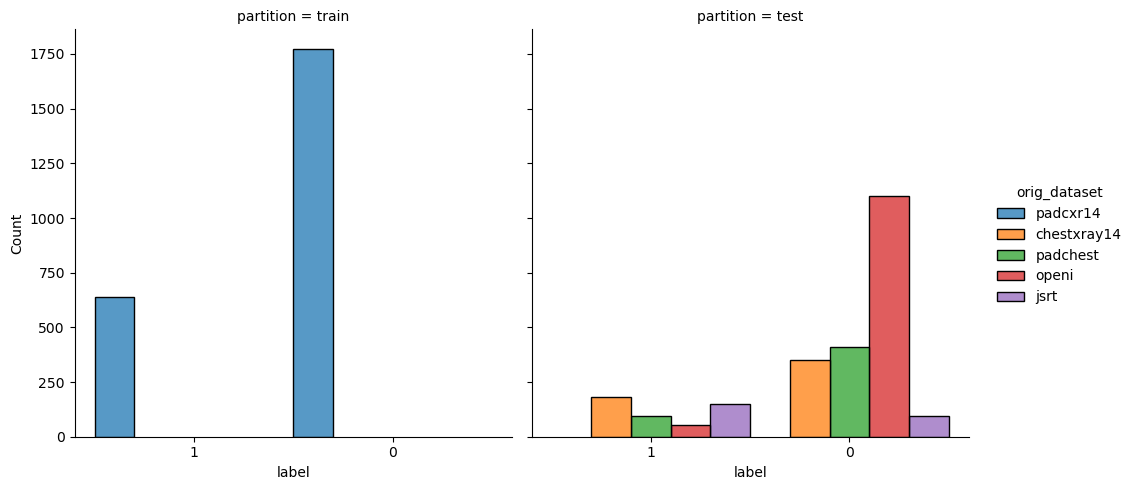

In [69]:
data_df['png'] = data_df['mha'].apply(lambda x: x[:-3]+"png")
data_df['label'] = data_df['label'].astype(str)
sns.displot(data_df, x='label',col='partition', hue='orig_dataset',multiple='dodge')

In [95]:
new_df = pd.DataFrame()
discard_df = pd.DataFrame()
add_df = pd.DataFrame()
for dataset in data_df.orig_dataset.unique():
    if data_df.query(f'orig_dataset == "{dataset}"').partition.unique()[0] == 'train':
        for partition in data_df.query(f'orig_dataset == "{dataset}"').partition.unique():
            samples = data_df.query(f'orig_dataset == "{dataset}" & partition == "{partition}"').copy()
            vc = samples.label.value_counts()
            if partition == "test":
                majority_label = vc.index[0]
                num_samples_to_remove = vc.iloc[0]-vc.iloc[1]
                maj_sample = samples.query(f"label=='{majority_label}'")[0:-num_samples_to_remove]
                new_df = pd.concat([new_df, maj_sample, samples.query(f"label=='{vc.index[1]}'") ]).reset_index(drop=True)
                discard_df = pd.concat([discard_df,samples.query(f"label=='{majority_label}'")[num_samples_to_remove:]]).reset_index(drop=True)
            else:
                ov_df = pd.DataFrame()
                minority_label = vc.index[1]
                num_minority_samples = vc.iloc[1]
                num_majority_samples = vc.iloc[0]
                majority_label = vc.index[0]
                multiplier = 1
                while num_minority_samples<num_majority_samples:
                    num_minority_samples+=vc.iloc[1]
                    multiplier += 1
                # print(f"Multiplier {multiplier} x {vc.iloc[1]} = {vc.iloc[1]*multiplier} : {vc.iloc[0]}")
                
                minority_samples = samples.query(f"label=='{minority_label}'").copy()
                for i in range(0,multiplier):
                    # keep adding undersampled class
                    ov_df = pd.concat([ov_df,minority_samples]).reset_index(drop=True)
                diff = len(ov_df) - num_majority_samples                
                new_df = pd.concat([new_df, ov_df[0:-diff], samples.query(f"label=='{majority_label}'") ]).reset_index(drop=True)
                add_df = pd.concat([add_df, ov_df[0:-diff]]).reset_index(drop=True)
                
    elif data_df.query(f'orig_dataset == "{dataset}"').partition.unique()[0] == 'test':
        samples = data_df.query(f'orig_dataset == "{dataset}" & partition == "test"').copy()
        vc = samples.label.value_counts()
        # print(vc)
        majority_label = vc.index[0]
        num_samples_to_remove = vc.iloc[0]-vc.iloc[1]
        # print(f"{dataset} remove: {vc.iloc[0]} - {num_samples_to_remove} = {vc.iloc[0]-num_samples_to_remove} == {vc.iloc[1]}")
        maj_sample = samples.query(f"label=='{majority_label}'")[num_samples_to_remove:]
        # print(f"len(maj_sample): {len(maj_sample)}")
        min_sample = samples.query(f"label=='{vc.index[1]}'")
        # print(f"len(min_sample): {len(min_sample)}")
        new_df = pd.concat([new_df, maj_sample, samples.query(f"label=='{vc.index[1]}'") ]).reset_index(drop=True)
        discard_df = pd.concat([discard_df,samples.query(f"label=='{majority_label}'")[-num_samples_to_remove:]]).reset_index(drop=True)
    else:
        print("ERROR")
        break

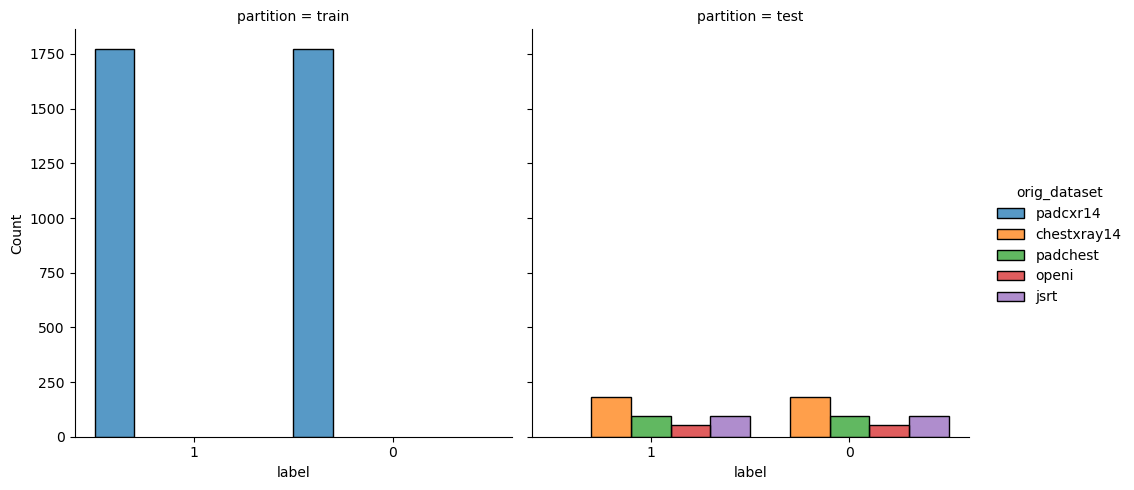

In [96]:
sns.displot(new_df, x='label',col='partition', hue='orig_dataset',multiple='dodge')

In [179]:
add_df['ds'] = add_df['orig_dataset'].apply(lambda x: "cxr14" if x =="chestxray14" else x ) 
discard_df['ds'] = discard_df['orig_dataset'].apply(lambda x: "cxr14" if x =="chestxray14" else x ) 
new_df['ds'] = new_df['orig_dataset'].apply(lambda x: "cxr14" if x =="chestxray14" else x ) 

In [164]:
!mkdir ../node21_all_samples 
!cp ../cxr14/arch_seg/flat_std_1024/train/nodule/* ../node21_all_samples
!cp ../cxr14/arch_seg/flat_std_1024/test/nodule/* ../node21_all_samples
!cp ../cxr14/arch_seg/flat_std_1024/train/normal/* ../node21_all_samples
!cp ../cxr14/arch_seg/flat_std_1024/test/normal/* ../node21_all_samples

!cp ../padchest/arch_seg/flat_std_1024/train/nodule/* ../node21_all_samples
!cp ../padchest/arch_seg/flat_std_1024/test/nodule/* ../node21_all_samples
!cp ../padchest/arch_seg/flat_std_1024/train/normal/* ../node21_all_samples
!cp ../padchest/arch_seg/flat_std_1024/test/normal/* ../node21_all_samples

!cp ../jsrt/arch_seg/flat_std_1024/train/nodule/* ../node21_all_samples
!cp ../jsrt/arch_seg/flat_std_1024/test/nodule/* ../node21_all_samples
!cp ../jsrt/arch_seg/flat_std_1024/train/normal/* ../node21_all_samples
!cp ../jsrt/arch_seg/flat_std_1024/test/normal/* ../node21_all_samples

!cp ../openi/arch_seg/flat_std_1024/test/normal/* ../node21_all_samples
!cp ../openi/arch_seg/flat_std_1024/test/normal/* ../node21_all_samples

cp: cannot stat '../openi/arch_seg/flat_std_1024/train/normal/*': No such file or directory


In [215]:
!rm -rf ../node21_combined
!mkdir ../node21_combined

In [217]:
import os, shutil
base_path = "/home/local/data/sophie/node21_combined/"

# copy files 
for i, row in new_df.iterrows():
    fp = os.path.join(base_path,row.ds, row.partition, "0_normal" if row.label == "0" else "1_nodule")
    if not os.path.exists(os.path.join(base_path,row.ds)):
        os.mkdir(os.path.join(base_path,row.ds))
    if not os.path.exists(os.path.join(base_path,row.ds, row.partition)):
        os.mkdir(os.path.join(base_path,row.ds, row.partition))
    if not os.path.exists(os.path.join(base_path,row.ds, row.partition,"0_normal" if row.label == "0" else "1_nodule")):
        os.mkdir(os.path.join(base_path,row.ds, row.partition,"0_normal" if row.label == "0" else "1_nodule"))
    
    from_f= row.png
    from_pth = os.path.join("../node21_all_samples",from_f)
    # if not os.path.exists(from_pth):
    #     print(f"{from_pth}")
    # print(f"Copy from: {from_pth}")
    f= row.png[:-4]+f"_idx{i}.png"
    to = os.path.join(fp,f)
    # print(f"Copy to: {to}")
    shutil.copy2(from_pth, to)

In [219]:
# !mkdir ../node21_combined/padcxr14/test ../node21_combined/padcxr14/test/cxr14 ../node21_combined/padcxr14/test/padchest
!mv ../node21_combined/cxr14/test/* ../node21_combined/padcxr14/test/cxr14
!mv ../node21_combined/padchest/test/* ../node21_combined/padcxr14/test/padchest

In [221]:
import os
print("PadchestCXR14: \nTrain 0: {}".format(len(os.listdir("/home/local/data/sophie/node21_combined/padcxr14/train/0_normal")))+
    "\nTrain 1: {}".format(len(os.listdir("/home/local/data/sophie/node21_combined/padcxr14/train/1_nodule")))+ 
    "\n=============\nCXR14:\nTest 0: {}".format(len(os.listdir("/home/local/data/sophie/node21_combined/padcxr14/test/cxr14/0_normal")))+
    "\nTest 1: {}\n".format(len(os.listdir("/home/local/data/sophie/node21_combined/padcxr14/test/cxr14/1_nodule")))
   )
print(
    "Padchest: \nTest 0: {}".format(len(os.listdir("/home/local/data/sophie/node21_combined/padcxr14/test/padchest/0_normal")))+
    "\nTest 1: {}\n".format(len(os.listdir("/home/local/data/sophie/node21_combined/padcxr14/test/padchest/1_nodule")))
   )

print("openi: \nTest 0: {}".format(len(os.listdir("/home/local/data/sophie/node21_combined/openi/test/0_normal")))+
    "\nTest 1: {}\n".format(len(os.listdir("/home/local/data/sophie/node21_combined/openi/test/1_nodule")))
   )
print("jsrt: \nTest 0: {}".format(len(os.listdir("/home/local/data/sophie/node21_combined/jsrt/test/0_normal")))+
    "\nTest 1: {}\n".format(len(os.listdir("/home/local/data/sophie/node21_combined/jsrt/test/1_nodule")))
   )

PadchestCXR14: 
Train 0: 1774
Train 1: 1774
CXR14:
Test 0: 180
Test 1: 180

Padchest: 
Test 0: 94
Test 1: 94

openi: 
Test 0: 54
Test 1: 54

jsrt: 
Test 0: 93
Test 1: 93



In [159]:
import os, shutil
base_path = "/home/local/data/sophie/node21_combined/"

# copy files 
for i, row in add_df.iterrows():
    fp = os.path.join(base_path,row.ds,"flat_std_1024", row.partition, "0_normal" if row.label == "0" else "1_nodule")
    # print(f"Copy from: {os.path.join(fp,row.png)}")
    to = os.path.join(fp,row.png[:-4]+f"_idx{i}.png")
    print(f"Copy to: {to}")
    # shutil.copy2(os.path.join(fp,row.png), os.path.join(fp,row.png[:-4]+f"_idx{i}.png"))

Copy to: /home/local/data/sophie/node21_combined/padcxr14/flat_std_1024/train/1_nodule/n0556_idx0.png
Copy to: /home/local/data/sophie/node21_combined/padcxr14/flat_std_1024/train/1_nodule/n0726_idx1.png
Copy to: /home/local/data/sophie/node21_combined/padcxr14/flat_std_1024/train/1_nodule/n0025_idx2.png
Copy to: /home/local/data/sophie/node21_combined/padcxr14/flat_std_1024/train/1_nodule/n0097_idx3.png
Copy to: /home/local/data/sophie/node21_combined/padcxr14/flat_std_1024/train/1_nodule/n0600_idx4.png
Copy to: /home/local/data/sophie/node21_combined/padcxr14/flat_std_1024/train/1_nodule/n0845_idx5.png
Copy to: /home/local/data/sophie/node21_combined/padcxr14/flat_std_1024/train/1_nodule/n0022_idx6.png
Copy to: /home/local/data/sophie/node21_combined/padcxr14/flat_std_1024/train/1_nodule/n0009_idx7.png
Copy to: /home/local/data/sophie/node21_combined/padcxr14/flat_std_1024/train/1_nodule/n0714_idx8.png
Copy to: /home/local/data/sophie/node21_combined/padcxr14/flat_std_1024/train/1_no

In [150]:
# delete files 
for _, row in discard_df.iterrows():#"label","png"]]:
    subdr = os.path.join(row.partition, row.ds) if row.ds == "cxr14" or "padchest" else row.ds
    # print(os.path.join(base_path,"padcxr14" if row.ds =="cxr14" or row.ds=="padchest" else row.ds,"arch_seg/flat_std_1024", subdr, "0_normal" if row.label == "0" else "1_nodule", row.png))
    try:
        os.remove(os.path.join(base_path,"padcxr14" if row.ds =="cxr14" or row.ds=="padchest" else row.ds,"flat_std_1024", subdr, "0_normal" if row.label == "0" else "1_nodule", row.png))
    except Exception as e:
        print(e)
        # try:
        #     subdr = os.path.join(row.partition, row.ds) if row.ds == "cxr14" or "padchest" else row.ds
        #     os.remove(os.path.join(base_path,"padcxr14" if row.ds =="cxr14" or row.ds=="padchest" else row.ds,"flat_std_1024", subdr, "0_normal" if row.label == "0" else "1_nodule", row.png))
        # except Exception as er:
        #     print(er)

[Errno 2] No such file or directory: '/home/local/data/sophie/node21_combined/padcxr14/flat_std_1024/test/cxr14/0_normal/c3695.png'
[Errno 2] No such file or directory: '/home/local/data/sophie/node21_combined/padcxr14/flat_std_1024/test/cxr14/0_normal/c3126.png'
[Errno 2] No such file or directory: '/home/local/data/sophie/node21_combined/padcxr14/flat_std_1024/test/cxr14/0_normal/c1837.png'
[Errno 2] No such file or directory: '/home/local/data/sophie/node21_combined/padcxr14/flat_std_1024/test/cxr14/0_normal/c2247.png'
[Errno 2] No such file or directory: '/home/local/data/sophie/node21_combined/padcxr14/flat_std_1024/test/cxr14/0_normal/c1204.png'
[Errno 2] No such file or directory: '/home/local/data/sophie/node21_combined/padcxr14/flat_std_1024/test/cxr14/0_normal/c0931.png'
[Errno 2] No such file or directory: '/home/local/data/sophie/node21_combined/padcxr14/flat_std_1024/test/cxr14/0_normal/c2545.png'
[Errno 2] No such file or directory: '/home/local/data/sophie/node21_combine

In [147]:
# !rm -rf ../node21_combined/padcxr14
# !mkdir ../node21_combined/padcxr14
# !cp -r /home/local/data/sophie/node21_corrected_oversampling/cxr14/flat_std_1024 /home/local/data/sophie/node21_combined/padcxr14
# !mkdir ../node21_combined/padcxr14/flat_std_1024/test/cxr14 ../node21_combined/padcxr14/flat_std_1024/test/padchest
# !cp -r /home/local/data/sophie/node21_corrected_oversampling/padchest/flat_std_1024/train/0_normal/* /home/local/data/sophie/node21_combined/padcxr14/flat_std_1024/train/0_normal/
# !cp -r /home/local/data/sophie/node21_corrected_oversampling/padchest/flat_std_1024/train/1_nodule/* /home/local/data/sophie/node21_combined/padcxr14/flat_std_1024/train/1_nodule 
# !cp -r /home/local/data/sophie/node21_corrected_oversampling/padchest/flat_std_1024/test/* /home/local/data/sophie/node21_combined/padcxr14/flat_std_1024/test/padchest
# !mv ../node21_combined/padcxr14/flat_std_1024/test/1_nodule/ ../node21_combined/padcxr14/flat_std_1024/test/cxr14 
# !mv ../node21_combined/padcxr14/flat_std_1024/test/0_normal/ ../node21_combined/padcxr14/flat_std_1024/test/cxr14

In [158]:
import os
print("PadchestCXR14: \nTrain 0: {}".format(len(os.listdir("/home/local/data/sophie/node21_combined/padcxr14/flat_std_1024/train/0_normal")))+
    "\nTrain 1: {}".format(len(os.listdir("/home/local/data/sophie/node21_combined/padcxr14/flat_std_1024/train/1_nodule")))+ 
    "\n=============\nCXR14:\nTest 0: {}".format(len(os.listdir("/home/local/data/sophie/node21_combined/padcxr14/flat_std_1024/test/cxr14/0_normal")))+
    "\nTest 1: {}\n".format(len(os.listdir("/home/local/data/sophie/node21_combined/padcxr14/flat_std_1024/test/cxr14/1_nodule")))
   )
print(
    "Padchest: \nTest 0: {}".format(len(os.listdir("/home/local/data/sophie/node21_combined/padcxr14/flat_std_1024/test/padchest/0_normal")))+
    "\nTest 1: {}\n".format(len(os.listdir("/home/local/data/sophie/node21_combined/padcxr14/flat_std_1024/test/padchest/1_nodule")))
   )

print("openi: \nTest 0: {}".format(len(os.listdir("/home/local/data/sophie/node21_combined/openi/flat_std_1024/test/0_normal")))+
    "\nTest 1: {}\n".format(len(os.listdir("/home/local/data/sophie/node21_combined/openi/flat_std_1024/test/1_nodule")))
   )
print("jsrt: \nTest 0: {}".format(len(os.listdir("/home/local/data/sophie/node21_combined/jsrt/flat_std_1024/test/0_normal")))+
    "\nTest 1: {}\n".format(len(os.listdir("/home/local/data/sophie/node21_combined/jsrt/flat_std_1024/test/1_nodule")))
   )

PadchestCXR14: 
Train 0: 1775
Train 1: 2414
CXR14:
Test 0: 180
Test 1: 180

Padchest: 
Test 0: 94
Test 1: 94

openi: 
Test 0: 1049
Test 1: 54

jsrt: 
Test 0: 94
Test 1: 121



In [157]:
import os
print("PadchestCXR14: \nTrain 0: {}".format(len(os.listdir("/home/local/data/sophie/node21_combined/padcxr14/flat_std_1024/train/0_normal")))+
    "\nTrain 1: {}".format(len(os.listdir("/home/local/data/sophie/node21_combined/padcxr14/flat_std_1024/train/1_nodule")))+ 
    "\n=============\nCXR14:\nTest 0: {}".format(len(os.listdir("/home/local/data/sophie/node21_combined/padcxr14/flat_std_1024/test/cxr14/0_normal")))+
    "\nTest 1: {}\n".format(len(os.listdir("/home/local/data/sophie/node21_combined/padcxr14/flat_std_1024/test/cxr14/1_nodule")))
   )
print(
    "Padchest: \nTest 0: {}".format(len(os.listdir("/home/local/data/sophie/node21_combined/padcxr14/flat_std_1024/test/padchest/0_normal")))+
    "\nTest 1: {}\n".format(len(os.listdir("/home/local/data/sophie/node21_combined/padcxr14/flat_std_1024/test/padchest/1_nodule")))
   )

print("openi: \nTest 0: {}".format(len(os.listdir("/home/local/data/sophie/node21_combined/openi/flat_std_1024/test/0_normal")))+
    "\nTest 1: {}\n".format(len(os.listdir("/home/local/data/sophie/node21_combined/openi/flat_std_1024/test/1_nodule")))
   )
print("jsrt: \nTest 0: {}".format(len(os.listdir("/home/local/data/sophie/node21_combined/jsrt/flat_std_1024/test/0_normal")))+
    "\nTest 1: {}\n".format(len(os.listdir("/home/local/data/sophie/node21_combined/jsrt/flat_std_1024/test/1_nodule")))
   )

PadchestCXR14: 
Train 0: 1775
Train 1: 2414
CXR14:
Test 0: 180
Test 1: 180

Padchest: 
Test 0: 94
Test 1: 94

openi: 
Test 0: 1049
Test 1: 54

jsrt: 
Test 0: 94
Test 1: 121

